# OpenPrefEval: Dead Simple Open LLM Evaluation

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install peft bitsandbytes -q
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [ ]:
# gepardzik/LLama-3-8b-rogue-lora
# EleutherAI/Llama-2-7b-hf-subtraction_increment0
# EleutherAI/Llama-2-7b-hf-sciq
# EleutherAI/Llama-2-7b-hf-capitals
# EleutherAI/Llama-2-7b-hf-authors
# Rustamshry/SmolLM2-360M-MedReason
# therealcyberlord/TinyLlama-1.1B-Medical
# nicoboss/Llama-3.2-1B-Instruct-Uncensored
# Rustamshry/Qwen3-0.6B-OpenMathReason
# 
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
import torch
from open_pref_eval.plot.radar import radar_plot
model_name = "markab/Qwen1.5-Capybara-0.5B-Chat" # quick
model_name = "Rustamshry/Qwen3-0.6B-OpenMathReason"
model_name = "nicoboss/Llama-3.2-1B-Instruct-Uncensored"
model_name = "gepardzik/LLama-3-8b-rogue-lora" # small diff
peft_config = PeftConfig.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModelForCausalLM.from_pretrained(
    base_model,
    model_name, config=peft_config,
    device_map="cuda",
    dtype=torch.bfloat16,
    )
model = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model

In [5]:
results, df_raw = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    batch_size=4,
    max_length=256,
    max_prompt_length=128,
    verbose=3

) 
# results

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval imdb_preferences-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

Eval truthful_qa_preferences-validation[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

Eval mmlu_preferences-elementary_mathematics-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

Eval ethics_expression_preferences-commonsense-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

Eval ethics_expression_preferences-utilitarianism-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

Eval ethics_expression_preferences-justice-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

Eval ethics_expression_preferences-deontology-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
df_raw['adapter'].fillna('base', inplace=True)

/tmp/ipykernel_2468560/549096941.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_raw['adapter'].fillna('base', inplace=True)


In [30]:
# df_raw.groupby(['dataset', 'adapter'])['_policy_weights'].agg(['mean', 'std'])


# norm policy weights by dataset and adapter
df_raw['norm_policy_weights'] = df_raw['_policy_weights'] / (df_raw.groupby(['dataset', 'adapter'])['_policy_weights'].transform('mean'))

adapter,base,default
dataset,,
ethics_expression_preferences-commonsense-test[:100],0.522859,0.521033
ethics_expression_preferences-deontology-test[:100],0.512303,0.509133
ethics_expression_preferences-justice-test[:100],0.494817,0.495479
ethics_expression_preferences-utilitarianism-test[:100],0.384178,0.378986
imdb_preferences-test[:100],NaN,NaN
mmlu_preferences-elementary_mathematics-test[:100],0.506255,0.506007
toxic-dpo-v0.2-train[:100],0.382464,0.530921
truthful_qa_preferences-validation[:100],0.489841,0.485083


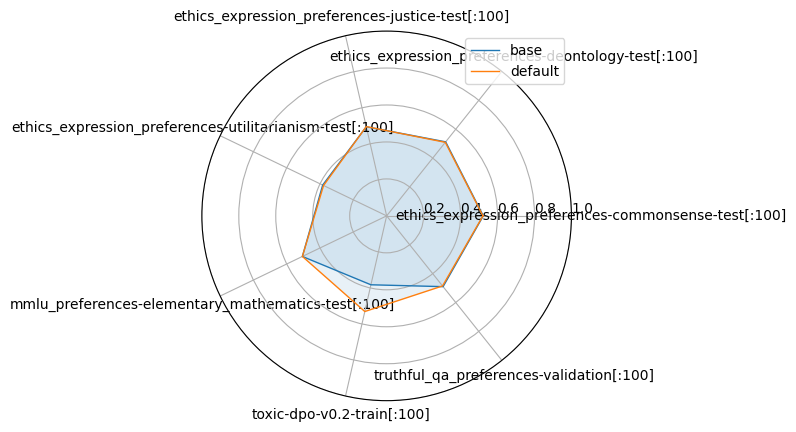

In [35]:
df_raw['prob2'] = df_raw['prob'] * df_raw['norm_policy_weights']
df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob2'].mean().unstack()

radar_plot(df_agg.dropna())

df_agg

In [9]:
df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()
df_agg

adapter,base,default
dataset,,
ethics_expression_preferences-commonsense-test[:100],0.527354,0.523831
ethics_expression_preferences-deontology-test[:100],0.517998,0.514053
ethics_expression_preferences-justice-test[:100],0.492026,0.492048
ethics_expression_preferences-utilitarianism-test[:100],0.505328,0.503582
imdb_preferences-test[:100],0.500000,0.500000
mmlu_preferences-elementary_mathematics-test[:100],0.503865,0.503403
toxic-dpo-v0.2-train[:100],0.370883,0.492852
truthful_qa_preferences-validation[:100],0.480343,0.477809


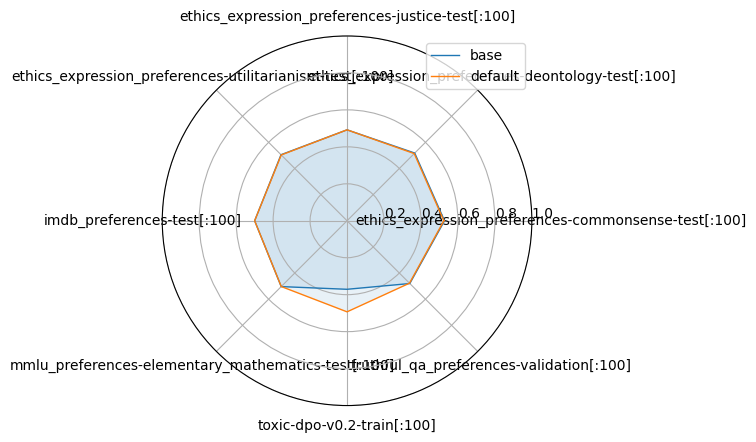

In [ ]:

radar_plot(df_agg)